## Import Necessary Libraries

In [85]:
import time
import graphviz # You need to install python-graphviz for this https://anaconda.org/conda-forge/python-graphviz

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import datetime as dt

from matplotlib import ticker
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


## Load the Data

In [2]:
blob_path = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
source_path = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'

start = time.perf_counter()
detroit_911 = pd.read_csv(blob_path, thousands = ",")#, nrows = 100000)
print(time.perf_counter() - start)

75.2389642


## Clean the Data

In [3]:
# Make a copy of the dataframe so that I don't have to redownload it every time I want to refresh.
detroit_df = detroit_911.copy()

# Count all the null values in the columns
null_values = detroit_df.isnull().sum().reset_index().rename(columns = {'index':'feature', 0: "null_values"})
null_values.sort_values(by = 'null_values', ascending = False, inplace = True)
null_values['null_ratio'] = (null_values['null_values'] / detroit_df.shape[0]) * 100
null_values['total'] = 100

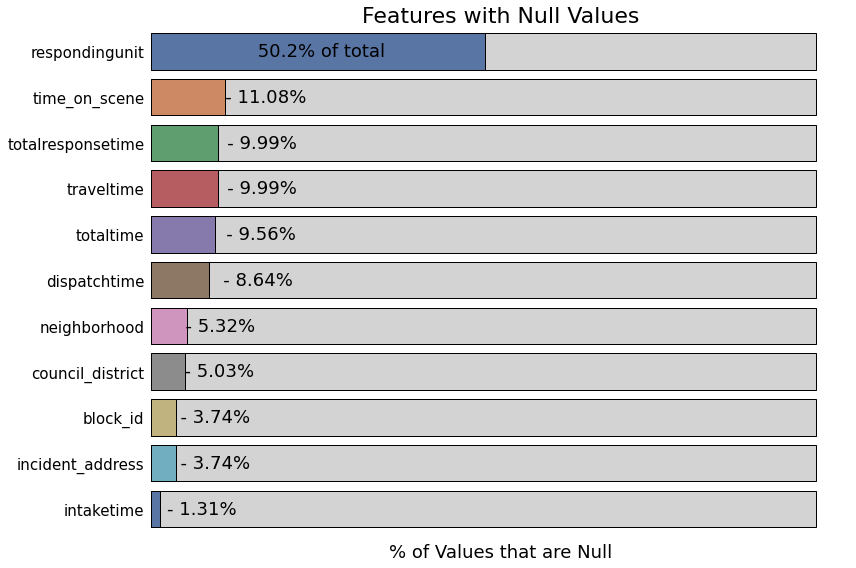

In [4]:
plt.rcParams['ytick.labelsize'] = 15

fig = plt.figure(figsize = (12,8))
plt.title('Features with Null Values', fontsize = 22)

null_ax = sns.barplot(data = null_values[(null_values['null_ratio'] > 0)], x='total', y='feature', color = 'lightgrey', edgecolor = 'black')
null_ax1 = sns.barplot(data = null_values[(null_values['null_ratio'] > 0)], x='null_ratio', y='feature', palette = 'deep', edgecolor = 'black')

null_ax.set_ylabel("")
null_ax.set_xlabel('% of Values that are Null', fontsize = 18)

null_ax.tick_params(bottom = False, left = False)
for c in null_ax.containers:
    labels = []
    for v in c:
        if (h := v.get_width()) == 100:
            lab = ""
        elif (h := v.get_width()) > 14:
            lab = f' {(h/100)*100:0.1f}% of total'
        elif (h := v.get_width()) > 7:
            lab = f'  {" "*25}- {(h/100)*100:0.2f}%'
        elif (h := v.get_width()) > 3:
            lab = f'  {" "*16}- {(h/100)*100:0.2f}%'
        else:
            lab = f'{" "*16}- {(h/100)*100:0.2f}%'
        labels.append(lab)

    null_ax.bar_label(c,labels=labels,label_type = 'center',fontsize = 18,color= 'black')#, weight = 'bold')
    
null_ax.set(xticklabels = [])
sns.despine(bottom = True, left = True)
fig.tight_layout()
plt.savefig('graphs/null_values.png')

In [5]:
detroit_df.head(5).T

,0,1,2,3,4
X,-82.986962,-83.185213,-83.146057,-83.191603,-83.175124
Y,42.408358,42.430914,42.43877,42.358257,42.360867
incident_id,201626400002,201626400019,201626400020,201626400024,201626400029
agency,DPD,DPD,DPD,DPD,DPD
incident_address,Promenade Ave & Roseberry St,Ardmore St & W 7 Mile Rd,Pembroke Ave & Prairie St,Joy Rd & Robson St,Littlefield St & Ellis St
zip_code,48213,48235,48221,48228,48228
priority,3,2,3,3,3
callcode,825030,811020,374030,825030,374030
calldescription,DISTURBANCE,AUTO X UNK INJ / IMPAIRED,RECOVER AUTO,DISTURBANCE,RECOVER AUTO
category,DISTURB,ACCUNK,RECAUTO,DISTURB,RECAUTO


### Drop Unused Features
> We dropped features that... Explain this further

In [6]:
# Drop columns that will not be used in algorithm
detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

### Fix Missing Priorities
> Explain what we are doing here. (Remember that some of the priorities were missing so we matched the call description up with a matching call description)

In [7]:
mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key   
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


### Drop two of the time columns
> Explain why we did this.

In [8]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)


### Convert timestamp to weekday

In [9]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

### Convert Timestamp to Part of Day

In [10]:
def get_daypart(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00')
    time = dt.datetime.strftime(time, '%H:%M:%S')
    if time < "06:00":
        time_of_day = "Early Morning"
    elif time >= "06:00" and time < "10:00":
        time_of_day = "Morning"
    elif time >= "10:00" and time < "12:00":
        time_of_day = "Late Morning"
    elif time >= "12:00" and time < "15:00":
        time_of_day = "Afternoon"
    elif time >= "15:00" and time < "18:00":
        time_of_day = "Late Afternoon"
    elif time >= "18:00" and time < "21:00":
        time_of_day = "Early Evening"
    elif time >= "21:00":
        time_of_day = "Evening"
    else:
        time_of_day = "FAILED"
    return time_of_day

detroit_df['day_part'] = detroit_df['call_timestamp'].apply(lambda x: get_daypart(x))


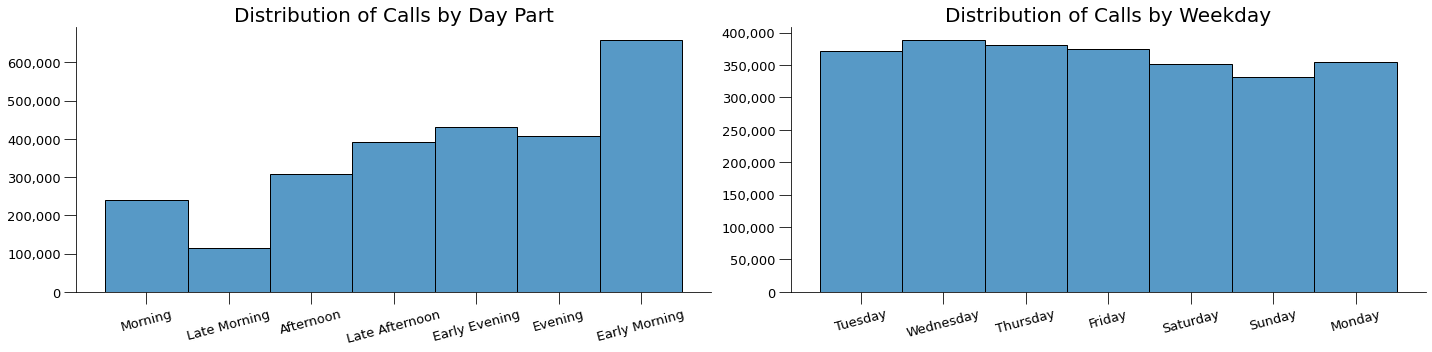

In [11]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(1,2, figsize = (20,5))
axs[0].set_title("Distribution of Calls by Day Part", fontsize = 20)
axs[1].set_title("Distribution of Calls by Weekday", fontsize = 20)
sns.histplot(data = detroit_df, x = 'day_part', ax = axs[0])
sns.histplot(data = detroit_df, x = 'weekday', ax = axs[1])
for ax in axs:
    ax.tick_params(size = 12)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation = 15)
sns.despine()
plt.tight_layout()
#plt.savefig('graphs/distribution_of_calls.png')
plt.show()

In [12]:
detroit_df.head()

,callcode,calldescription,call_timestamp,precinct_sca,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,825030,DISTURBANCE,2016/09/20 09:36:12+00,910A,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning
1,811020,AUTO X UNK INJ / IMPAIRED,2016/09/20 09:46:32+00,1201,No,2.7,5.2,6.4,59.1,Tri-Point,2.0,2,Tuesday,Morning
2,374030,RECOVER AUTO,2016/09/20 09:48:24+00,123B,No,4.9,NaN,NaN,NaN,Oak Grove,2.0,3,Tuesday,Morning
3,825030,DISTURBANCE,2016/09/20 09:50:29+00,0207,No,1.4,3.4,7.6,41.7,We Care Community,7.0,3,Tuesday,Morning
4,374030,RECOVER AUTO,2016/09/20 09:54:37+00,28A,No,3.0,1645.3,NaN,NaN,Barton-McFarland,7.0,3,Tuesday,Morning


### Drop columns that will not be used for prediction.

In [13]:
detroit_df.drop(columns = ['callcode','call_timestamp','precinct_sca'], inplace = True)

In [14]:
# We initially wanted to use call description, but it reduced the accuracy of the prediction
detroit_df.drop(columns = ['calldescription'], inplace = True) 

### Create a save point so that data reloading is unneccessary.

In [15]:
backup_detroit = detroit_df.copy()

# Checkpoint
### To avoid overwriting detroit_df during a reload, run from this point

In [16]:
backup_detroit.head(1)

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,neighborhood,council_district,priority,weekday,day_part
0,No,2.2,528.6,15.5,120.5,Wade,4.0,3,Tuesday,Morning


In [17]:
detroit_df = backup_detroit.copy()

In [18]:
detroit_df_subset = detroit_df.head(5000)

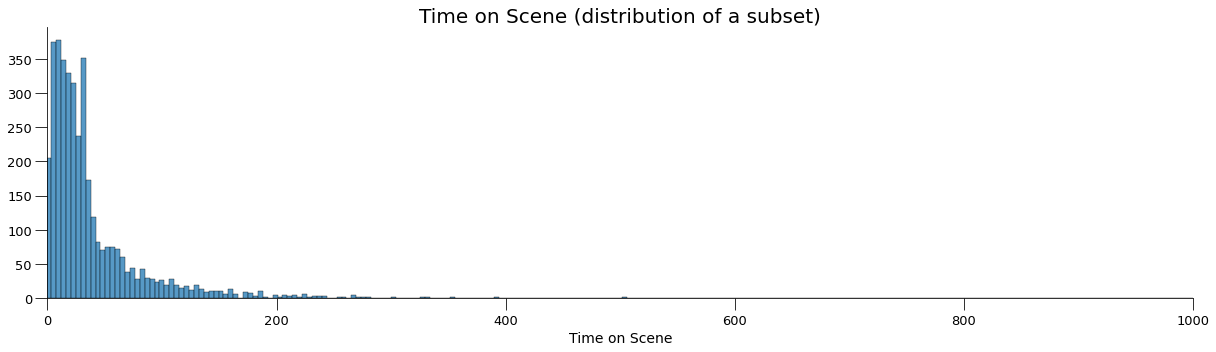

In [19]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
    
fig = plt.figure(figsize = (17,5))
plt.title('Time on Scene (distribution of a subset)', fontsize = 20)
hist_ax = sns.histplot(data = detroit_df_subset, x='time_on_scene')
hist_ax.set_xlabel('Time on Scene', fontsize = 14)
hist_ax.set_ylabel('')
hist_ax.tick_params(size = 12)
hist_ax.set_xlim([0,1000])
sns.despine()
plt.tight_layout()
#plt.savefig('graphs/time_on_scene_distribution.png')
plt.show()


### Establish what we are trying to predict.
> We want to know, given certain characteristics, what is the likelihood that an officers<br>
time on scene will be more than the average (around 32.7 minutes).

In [20]:
data_mean = detroit_df['time_on_scene'].mean()
detroit_df['on_scene_time_gt_mean'] = detroit_df['time_on_scene'].apply(lambda x: 1 if x > data_mean else 0)

### Drop the column that was used to generate our prediction column because it will correlate too highly.

In [21]:
detroit_df.drop(columns = ['time_on_scene'], inplace = True)

### Establish X - The independent features

In [22]:
X = detroit_df.drop(columns = ['on_scene_time_gt_mean']).copy()

### Establish Y - The dependent feature

In [23]:
y = detroit_df['on_scene_time_gt_mean'].copy()

In [24]:
X.select_dtypes('object')

,officerinitiated,neighborhood,priority,weekday,day_part
0,No,Wade,3,Tuesday,Morning
1,No,Tri-Point,2,Tuesday,Morning
2,No,Oak Grove,3,Tuesday,Morning
3,No,We Care Community,3,Tuesday,Morning
4,No,Barton-McFarland,3,Tuesday,Morning
...,...,...,...,...,...
2551995,No,Oakman Blvd Community,3,Monday,Late Morning
2551996,No,North Corktown,2,Monday,Late Morning
2551997,No,Oakman Blvd Community,3,Monday,Late Morning
2551998,No,Warrendale,1,Monday,Late Morning


### Get Dummies for categorical data.

In [25]:
X_encoded = pd.get_dummies(X)

In [26]:
X_encoded.columns = X_encoded.columns.str.replace(" ", "_")

In [27]:
X_encoded.head()

,intaketime,dispatchtime,traveltime,council_district,officerinitiated_No,officerinitiated_Yes,neighborhood_Airport_Sub,neighborhood_Arden_Park,neighborhood_Aviation_Sub,neighborhood_Bagley,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,day_part_Afternoon,day_part_Early_Evening,day_part_Early_Morning,day_part_Evening,day_part_Late_Afternoon,day_part_Late_Morning,day_part_Morning
0,2.2,528.6,15.5,4.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2.7,5.2,6.4,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,4.9,NaN,NaN,2.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.4,3.4,7.6,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,3.0,1645.3,NaN,7.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [28]:
X_encoded.fillna(0, inplace = True)

### Preserve the time needed to run various combinations.

In [37]:
running_time = []
models = []

## Primary Algorithms

In [83]:
def logistic_regression(X, y):
    """ This model provides the baseline so we can test the accuracy of our model. """
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state = 1)

    log_reg = LogisticRegression(max_iter = 10000)

    log_reg.fit(X_train, y_train)
    log_coef = log_reg.coef_
    log_intercept = log_reg.intercept_

    score = log_reg.score(X_test, y_test)

    predictions = log_reg.predict(X_test)
    return score, predictions, y_test

In [38]:
def tune_classifier(X,y):
    """ This model was used for tuning hyper parameters. """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )
    
    optimal_params = GridSearchCV(
        estimator=xgb.XGBClassifier(
            objective='binary:logistic',
            seed = 42,
            subsample=0.9,
            colsample_bytree=0.5
        ),
        param_grid=param_grid1,
        scoring='roc_auc',
        verbose=2,
        n_jobs=10,
        cv=3
    )
    
    optimal_params.fit(X_train, 
                y_train, 
                verbose = False,
                early_stopping_rounds=10, 
                eval_metric='auc',
                eval_set=[(X_test, y_test)]
               )
    
    return(optimal_params.best_params_)

In [38]:
def run_classifier(X,y):
    """ This was the final model. """
    print('\nNow splitting the data.\n')
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )
    
    print('\nNow instantiating the model.\n')
    xgb_reg = xgb.XGBClassifier(objective='binary:logistic',
                               seed = 42,
                               gamma=1,
                               learning_rate=0.06,
                               max_depth=4, # This must be an integer, so rounded down from optimal.
                               reg_lambda=27.143,
                               scale_pos_weight=2.714,
                               subsample=0.9,
                               colsample_bytree=0.5)
    
    print('\nNow Fitting the Model\n')
    xgb_reg.fit(X_train,
                y_train,
                verbose = 2,
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)]
               )
    accuracy = xgb_reg.score(X_test, y_test)
    print(f'Score: {accuracy}')
    return accuracy, xgb_reg, X_test, y_test

In [38]:
def get_first_tree(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 42, stratify = y
    )
    
    xgb_reg = xgb.XGBClassifier(objective='binary:logistic',
                               seed = 42,
                               subsample=0.9,
                               colsample_bytree=0.5,
                               n_estimators=1)
    
    xgb_reg.fit(X_train, y_train)
    return xgb_reg

In [86]:
    
hyper_scores = {
    'max_depth': [],
    'learning_rate': [],
    'gamma': [], 
    'reg_lambda': [],
    'scale_pos_weight': [],
    'accuracy': []
}

param_grid1 = {
    'max_depth': [3,4,5,6,7,8],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0, 2.0], 
    'reg_lambda': [10.0, 20, 100],
    'scale_pos_weight': [1,2,3,4,5],
}

for size in range(2400000,2500000, 100000):
    print(f'\nModel for {size} rows.')
    X_subset = X_encoded.head(size)
    y_subset = y.head(size)

    start_time = time.perf_counter()

    #optimal_metrics = tune_classifier(X_subset,y_subset) # <- For tuning
    #score, xgb_final_model, X_test, y_test = run_classifier(X_subset, y_subset) # <- For Prediction
    #tree_model = get_first_tree(X_subset, y_subset) # <- For Tree Visual
    #score, predictions, y_test = logistic_regression(X_subset, y_subset)
    #running_time.append([size, time.perf_counter() - start_time, score])
    #models.append(xgb_final_model)
    #print(running_time)
    break


Model for 2400000 rows.


In [ ]:
assert 1 == 2

In [43]:
#final_model = models[0]
#prediction = final_model.predict(X_test)

In [87]:
def plot_confusion_matrix(y_test, prediction, title):

    cf_matrix = confusion_matrix(y_test, prediction)

    fig = plt.figure(figsize = (8,8))
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                     fmt='.2%', cmap='Blues', cbar=False,
                     annot_kws={"fontsize": 15, 'weight':'bold'})

    ax.set_title(title, fontsize = 22);
    ax.set_xlabel('\nPredicted', fontsize = 15)
    ax.set_ylabel('Actual', fontsize = 15);

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Under 32.7 Minutes','Over 32.7 Minutes'])
    ax.yaxis.set_ticklabels(['Under 32.7 Minutes','Over 32.7 Minutes'])

    ## Display the visualization of the Confusion Matrix.
    plt.savefig(f'graphs/{title.lower().replace(" ","_")}.png')
    plt.show()

def visualize_optimized():
    initial_data = pd.read_csv('data_output/optimized_score_results_auc.csv')
    initial_data['minutes'] = initial_data['elapsed_time']/60
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    plt.suptitle('Optimized Model Results', fontsize = 22)
    sns.scatterplot(data = initial_data, x = 'row_count', y = 'minutes', s=180, edgecolor = 'black', ax = axs[0])
    sns.scatterplot(data = initial_data, x = 'row_count', y='score_auc', s=180, edgecolor = 'black', ax = axs[1])
    
    targets = ['Time Elapsed', 'Accuracy Score']
    for i, ax in enumerate(axs):
        ax.set_title(targets[i].replace("_"," ").title(), fontsize = 19)
        ax.tick_params(size = 12)
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_xlabel('')
   
    axs[0].set_ylabel('Time Elapsed (minutes)', fontsize = 13)
    axs[1].set_ylabel('Accuracy', fontsize = 13)
    axs[1].set_xlabel('Number of Observations', fontsize = 13)
    
    plt.tight_layout()
    plt.savefig('graphs/optimized_results.png')
    plt.show()


def visualize_tuning():
    elapsed_df = pd.read_csv('data_output/tuning_results.csv')
    
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13

    fig = plt.subplots(figsize = (15,5))
    plt.title("Time for Tuning", fontsize = 22)
    ax = sns.scatterplot(data = elapsed_df, x = 'num_rows', y='runtime_mins', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red')
    ax = sns.lineplot(data = elapsed_df[(elapsed_df.num_rows != 3000)], x = 'num_rows', y='runtime_mins', linestyle = 'dashed', color= 'red')
    plt.axvspan(110000, 150000, color = 'red', alpha = .2)

    ax.set_xlabel('Number of Rows', fontsize = 14)
    ax.set_ylabel('Runtime (Minutes)', fontsize = 14)
    ax.ticklabel_format(style = 'plain')
    ax.tick_params(size = 12)
    ax.set_ylim([-10,100])
    ax.set_xlim([-10,130000])
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.annotate(' Total\n\nSystem\n\nFailure', xy=(116500,20), fontsize = 18)
    sns.despine()
    plt.tight_layout()
    #plt.savefig('graphs/tuning_time.png', transparent = False)


def visualize_optimization_results():
    elapsed_df = pd.read_csv('data_output/tuning_results.csv')
    fig, axs = plt.subplots(5,1, figsize = (17,10), gridspec_kw={'height_ratios':[.3,.3,.3,.3,.3]}, sharex = False)
    fig.suptitle("Optimal Parameters (average of results)", fontsize = 22)
    sns.scatterplot(data = elapsed_df, x = 'num_rows', y='gamma', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red', ax=axs[0])
    sns.scatterplot(data = elapsed_df, x = 'num_rows', y='learning_rate', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red', ax=axs[1])
    sns.scatterplot(data = elapsed_df, x = 'num_rows', y='max_depth', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red', ax=axs[2])
    sns.scatterplot(data = elapsed_df, x = 'num_rows', y='reg_lambda', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red', ax=axs[3])
    sns.scatterplot(data = elapsed_df, x = 'num_rows', y='scale_pos_weight', s = 180, alpha = 0.8, edgecolor = 'black', color = 'red', ax=axs[4])
    
    targets = ['gamma','learning_rate','max_depth','reg_lambda','scale_pos_weight']
    gap = [.1,.006,.15,5,-.43]
    for i, ax in enumerate(axs):
        ax.set_title(targets[i].replace("_"," ").title(), fontsize = 19)
        ax.axhline(elapsed_df[targets[i]].mean(), color = 'black', linestyle = 'dashed')
        avg = elapsed_df[targets[i]].mean()
        ax.annotate(f'Average Best: {round(avg,3)}', xy=(20000, avg + (gap[i])), fontsize = 15)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(size = 12)
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    #plt.savefig('graphs/optimal_params.png')
    



def visualize_first_attempts():
    score_frame = pd.read_csv('data_output/prediction_scores_xgb_baseline.csv')
    sns.set_style('ticks')

    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13

    fig, axs = plt.subplots(3, 1, figsize = (18,13), gridspec_kw={'height_ratios':[.5,.5,.3]}, sharex = False)

    axs[0].set_title('Model Predicting Time On Scene (less than 32 minutes on scene)', fontsize = 22)
    axs[1].set_title('Model Predicting Time On Scene (less than 2 hours on scene)', fontsize = 22)
    axs[2].set_title('Model Differences Based on Predicted "Time on Scene" ', fontsize = 22)

    sns.scatterplot(data = score_frame, x = 'num_observations', y = '32.7 minutes', s = 180, alpha = .7, edgecolor = 'black', color = 'red', ax = axs[0])
    sns.scatterplot(data = score_frame, x = 'num_observations', y= '120 minutes', s= 180, alpha = .7, edgecolor = 'black', color = 'blue', ax = axs[1])
    sns.scatterplot(data = score_frame, x = 'num_observations', y= 'difference', s= 180, alpha = .7, edgecolor = 'black', color = 'darkgreen', ax = axs[2])

    axs[2].set_ylim([0.165,.256])
    targets = ['32.7 minutes','120 minutes','difference']
    for i, ax in enumerate(axs):
        ax.ticklabel_format(style = 'plain')
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.tick_params(size = 12)
        ax.set_xlabel("Number of Observations", fontsize = 14)
        ax.set_ylabel('Accuracy', fontsize = 14)
        ax.axhline(score_frame[targets[i]].max(), color = 'black', linestyle = 'dashed')
        ax.axhline(score_frame[targets[i]].min(), color = 'black', linestyle = 'dashed')
    axs[2].set_ylabel('Difference', fontsize = 14)
    axs[1].set_xlabel('')
    sns.despine()
    plt.tight_layout()
    #plt.savefig("XGB_classifier_first_attempts.png")
    
    
#visualize_first_attempts()
#visualize_optimization_results()
#plot_confusion_matrix(y_test, predictions, 'Logistic Regression Confusion Matrix')
#visualize_tuning()
#visualize_optimized()

In [ ]:

prediction_scores.rename(columns = {'accuracy': '120 minutes', '32 minute': '32.7 minutes', 'size': 'num_observations'}, inplace = True)

In [ ]:
prediction_scores['difference'] = prediction_scores['120 minutes'] - prediction_scores["32.7 minutes"]
prediction_scores

In [ ]:
prediction_scores.to_csv('prediction_scores_xgb_baseline.csv', index = False)

In [ ]:
other_data = pd.read_csv('xgb_classifier_attempt_1.csv')
other_data = other_data.tail(5)

In [ ]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

fig, axs = plt.subplots(1,2, figsize = (20,10))
fig.suptitle("Accuracy vs. Number of Observations", fontsize = 22)
axs[0].set_title("(Not Including Call Description)", fontsize = 15)
axs[1].set_title("(Including Call Description)", fontsize = 15)

sns.scatterplot(data = other_data, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[0])
axs[0].axhline(other_data['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[0].axhline(other_data['accuracy'].mean(), color = 'black', linestyle = 'dashed')

sns.scatterplot(data = score_frame, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red', ax = axs[1])
axs[1].axhline(score_frame['accuracy'].max(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].min(), color = 'black', linestyle = 'dashed')
axs[1].axhline(score_frame['accuracy'].mean(), color = 'black', linestyle = 'dashed')

axs[0].axhline(.952, color = 'red')
axs[1].axhline(.952, color = 'red')

axs[0].set_xlabel('Number of Observations', fontsize = 15)
axs[0].set_ylabel('Accuracy', fontsize = 15)
axs[0].tick_params(size = 10)
axs[0].set_xlim([1900000,2450000])
axs[0].set_ylim([.95,.955])
axs[0].ticklabel_format(style = 'plain')
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = other_data[(other_data.accuracy == other_data["accuracy"].max())]["size"].values[0]
least_accurate = other_data[(other_data.accuracy == other_data["accuracy"].min())]["size"].values[0]
axs[0].annotate(f'Max Accuracy: {(other_data["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9536], 
            fontsize = 12)
axs[0].annotate(f'Min Accuracy: {(other_data["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.95156], 
            fontsize = 12)


axs[1].set_xlabel('Number of Observations', fontsize = 15)
axs[1].set_ylabel('Accuracy', fontsize = 15)
axs[1].tick_params(size = 10)
axs[1].set_xlim([1900000,2450000])
axs[1].set_ylim([.95,.955])
axs[1].ticklabel_format(style = 'plain')
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
most_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].max())]["size"].values[0]
least_accurate = score_frame[(score_frame.accuracy == score_frame["accuracy"].min())]["size"].values[0]
axs[1].annotate(f'Max Accuracy: {(score_frame["accuracy"].max()) * 100}% at {"{:,}".format(most_accurate)} observations', 
            xy= [1950000,.9532], 
            fontsize = 12)
axs[1].annotate(f'Min Accuracy: {(score_frame["accuracy"].min()) * 100}% at {"{:,}".format(least_accurate)} observations', 
            xy= [2050000,.951], 
            fontsize = 12)

sns.set

sns.despine()
#plt.savefig("XGB_classifier_vs-2")

In [ ]:
bst = tree_model.get_booster()

In [ ]:
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#1AA7EC'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#FFFF00'}


tree_graph = xgb.to_graphviz(tree_model,
                num_trees=0,
                size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params, 
                bgcolor = 'transparent',
                yes_color = 'green',
                no_color = 'red'
               )

tree_graph.render('graphs/single_tree_sample', format='png', view = False)